# MPSC Inference and Results lookup
<hr >

> In this notebook we will check our model performance in more details

## Table Of Content
<hr >

> 1. [Imports and Load](#Imports-and-Load)
>     - [Load data](#Load-data)
>     - [Load Model and Predict](#Load-Model-and-Predict)
> 2. [Error-analysis](#Error-analysis)
>     - [a quick look on the top worst predictions](#a-quick-look-on-the-top-worst-predictions)
>     - [which category has worst mae](#which-category-has-worst-mae)
>     - [name wordcloud based on error](#name-wordcloud-based-on-error)
>     - [item_description wordcloud based on error](#item_description-wordcloud-based-on-error)

## Imports and Load
<hr >

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # for creating interactive visualizations
import seaborn as sns # data visualization library based on matplotlib
from wordcloud import WordCloud, STOPWORDS
import fasttext # used here for language detection
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers, Model
import joblib

In [2]:
DATA_PATH = '../data/'
MODELS_PATH = '../models/'

TARGET = 'price'
SEED = 123
MAX_NUM_WORDS_NAME = 40000
MAX_NUM_WORDS_DESC = 80000
MAX_SEQ_LEN_NAME = 20
MAX_SEQ_LEN_DESC = 64

In [3]:
def plot_hist(series_, bins, title, figsize=(16, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(title=title)
    series_.hist(bins=bins)
    plt.axvline(series_.mean(), color='r', linestyle='dashed', linewidth=2)
    
def plot_bars(title, data, x, y, n_bars, figsize=(16, 4), palette='Blues_r', rotation=45, horizontalalignment='right'):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(title=title)
    sns.barplot(data=data.iloc[:n_bars], x=x, y=y, palette=sns.color_palette(palette, n_colors=n_bars+n_bars//6), ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, horizontalalignment=horizontalalignment)
    plt.show()
    
def plot_violin(data, x, y, hue, figsize=(16, 4), rotation=45, horizontalalignment='right'):
    fig, ax = plt.subplots(figsize=figsize)
    sns.violinplot(data=df, x=x, y=y, hue=hue)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, horizontalalignment=horizontalalignment)
    plt.show()
    
def plot_wordclouds(dfs, sub_titles, title, figsize=(24, 16)):
    len_dfs = len(dfs)
    plt.figure(figsize=figsize)
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.suptitle(title, fontsize=18, y=0.95)
    for i in range(len_dfs):
        wordcloud.generate(' '.join(dfs[i]))
        ax = plt.subplot(int(np.ceil(len_dfs/ 3)), 3, i+1)
        ax.set_title(f'{sub_titles[i]}', fontsize=16)
        plt.imshow(wordcloud)
        plt.axis('off')
    
wordcloud = WordCloud(background_color="white", max_font_size=50, max_words=1000, stopwords=STOPWORDS)
fmodel = fasttext.load_model(MODELS_PATH+ 'lid.176.ftz')

In [4]:
class Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    
class ColumnSelector(Transformer):
    def __init__(self, column=None, columns=None, fillna_value=None, fillna_from_column=None):
        self.column = column
        self.columns = columns
        self.fillna_value = fillna_value
        self.fillna_from_column = fillna_from_column
    
    def transform(self, df):
        if self.column and self.columns:
            raise Exception('You can not use both option [column, columns]')
        elif self.column:
            series = df[self.column]
        elif self.columns:
            series = df.apply(lambda x: ' '.join([str(x[f]) for f in self.columns]), axis=1)
        else:
            raise Exception('You have to chose one option [column, columns]')

        if self.fillna_from_column:
            series = series.fillna(df[self.fillna_from_column])
            
        if self.fillna_value:
            series = series.fillna(self.fillna_value)
        
        return series
    
    
class SubCategorySpliter(Transformer):
    def __init__(self, delimiter='/', maxsplit=2, nth_split=0):
        self.delimiter = delimiter
        self.nth_split = nth_split
        self.maxsplit = maxsplit
        
    def transform(self, series):
        return series.apply(lambda x: x.split(self.delimiter, self.maxsplit)[self.nth_split])
    
    
class SeriesToArray(Transformer):
    def __init__(self, shape=(-1, 1)):
        self.shape = shape
        
    def transform(self, series):
        return series.values.reshape(self.shape)
    
    
class TextToSeq(Transformer):
    def __init__(
        self,
        num_words=None,
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
        lower=True,
        maxlen=100,
        sparse=True,
        dtype=np.uint32
    ):
        self.num_words = num_words
        self.filters = filters
        self.lower = lower
        self.maxlen = maxlen
        self.sparse = sparse
        self.dtype = dtype
        
    def fit(self, series, y=None):
        self.tokenizer = Tokenizer(num_words=self.num_words, filters=self.filters, lower=self.lower)
        self.tokenizer.fit_on_texts(series)
        
        return self
        
    def transform(self, series):
        seqs = self.tokenizer.texts_to_sequences(series)
        pad_seqs = pad_sequences(seqs, maxlen=self.maxlen, dtype=self.dtype)
        if self.sparse:
            pad_seqs = csr_matrix(pad_seqs)
        
        return pad_seqs
    
    
class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, pipes, target, batch_size=1024, train=True, shuffle=True):
        self.df = df
        self.pipes = pipes
        self.target = target
        self.train = train
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.df)/ self.batch_size))
    
    def __getitem__(self, idx):
        sub_idxs = self.idxs[idx*self.batch_size:(idx+1)*self.batch_size]
        sub_df = self.df.iloc[sub_idxs]
        X, y = self.__data_generation(sub_df)
        
        return X, y

    def on_epoch_end(self):
        self.idxs = np.arange(len(self.df))
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __data_generation(self, sub_df):
        X = [pipe.transform(sub_df) for pipe in self.pipes]
        if self.train:
            return X, np.log1p(sub_df[self.target].values)
        
        return X

### Load data

In [5]:
df_test = pd.read_csv(DATA_PATH+ 'mpsc_test.csv')
df_test['shipping'] = df_test['shipping'].map({0: 'Free shipping', 1: 'Shipping fees'})
df_test['item_condition_id'] = df_test['item_condition_id'].map({1: 'New', 2: 'Like new', 3: 'Good', 4: 'Fair', 5: 'Poor'})
pipes = joblib.load(MODELS_PATH+ 'pipes.pkl')
dg_test = DataGenerator(df=df_test, pipes=pipes, target=TARGET, batch_size=2**12, shuffle=False)

### Load Model and Predict

In [6]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    
class CustomOutputLayer(layers.Layer):
    def __init__(self, min_val, max_val, **kwargs):
        super(CustomOutputLayer, self).__init__(**kwargs)
        self.min_val = min_val
        self.max_val = max_val
        
    def call(self, inputs):
        outputs = tf.sigmoid(inputs)* (self.max_val- self.min_val)+ self.min_val
        output = tf.reduce_mean(outputs, axis=1, keepdims=True)
        
        return output
        
def get_model(seq_1_len, seq_2_len, feats_len, seq_1_max, seq_2_max, out_min_val, out_max_val, use_cuslayer=True):
    seq_1 = layers.Input((seq_1_len,))
    s_1 = layers.Embedding(seq_1_max, 128)(seq_1)
    s_1 = TransformerBlock(128, 4, 128)(s_1)
    s_1 = layers.GlobalAvgPool1D()(s_1)
    
    seq_2 = layers.Input((seq_2_len,))
    s_2 = layers.Embedding(seq_2_max, 128)(seq_2)
    s_2 = TransformerBlock(128, 4, 128)(s_2)
    s_2 = layers.GlobalAvgPool1D()(s_2)
    
    rest_ = layers.Input((feats_len,))
    
    vec = layers.Concatenate(axis=1)([s_1, s_2, layers.Dense(64)(rest_)])
    vec = layers.Dense(64)(vec)
    if use_cuslayer:
        out = CustomOutputLayer(out_min_val, out_max_val)(vec)
    else:
        out = layers.Dense(1)(vec)
        
    model = Model(inputs=[seq_1, seq_2, rest_], outputs=[out])
    
    return model

In [7]:
model_1 = get_model(pipes[0].transform(df_test.iloc[0:1]).shape[1],
                  pipes[1].transform(df_test.iloc[0:1]).shape[1],
                  pipes[2].transform(df_test.iloc[0:1]).shape[1],
                  MAX_NUM_WORDS_NAME,
                  MAX_NUM_WORDS_DESC,
                  0,
                  8
                 )
model_1.load_weights(MODELS_PATH+ 'model_1_weights.hdf')
df_test['pred_price'] = np.expm1(model_1.predict(dg_test, verbose=1))

2022-01-27 11:47:01.079375: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


73/73 [==============================] - 256s 3s/step


## Test Data EDA

In [8]:
df_test['item_description'] = df_test['item_description'].fillna('No description yet')
df_test['category_name'] = df_test['category_name'].fillna('Other/Other/Other')
df_test['brand_name'] = df_test['brand_name'].fillna('Other')
df_test['main_cat'] = df_test['category_name'].apply(lambda x: x.split('/', maxsplit=2)[0])
df_test = df_test[[col for col in df_test.columns if not 'price' in col]+ ['price', 'pred_price']].drop('train_id', axis=1)

<hr >

Mean price is 26.73179048049456


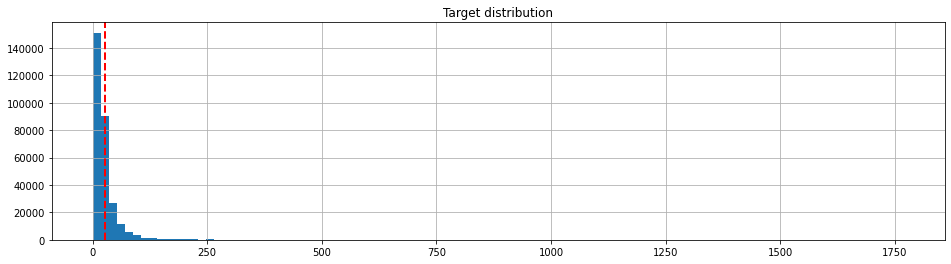

In [9]:
# First thing we can plot is the Target distribution
plot_hist(df_test[TARGET], bins=100, title='Target distribution')
print(f'Mean price is {df_test[TARGET].mean()}')

> We can see that price range and its mean are similar to train data

### A look at brands

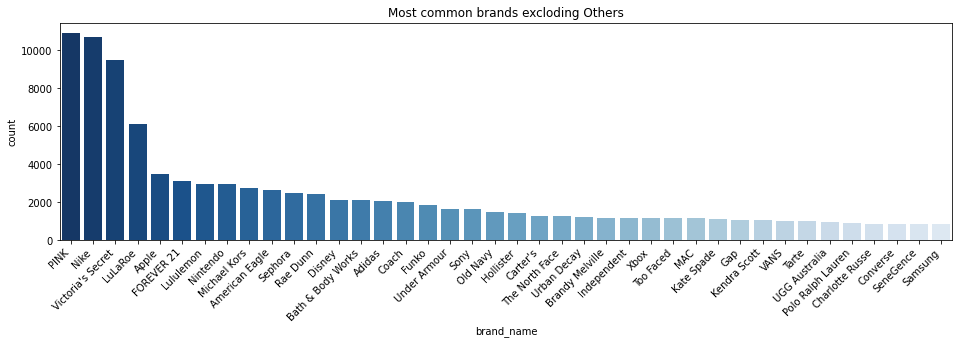

In [10]:
# plot the most common brands
df_ = df_test[df_test['brand_name'] != 'Other'].groupby('brand_name')[TARGET].count().reset_index()
df_.columns = ['brand_name', 'count']
df_ = df_.sort_values('count', ascending=False)
plot_bars('Most common brands excloding Others', df_, x='brand_name', y='count', n_bars=40)

### name analysis

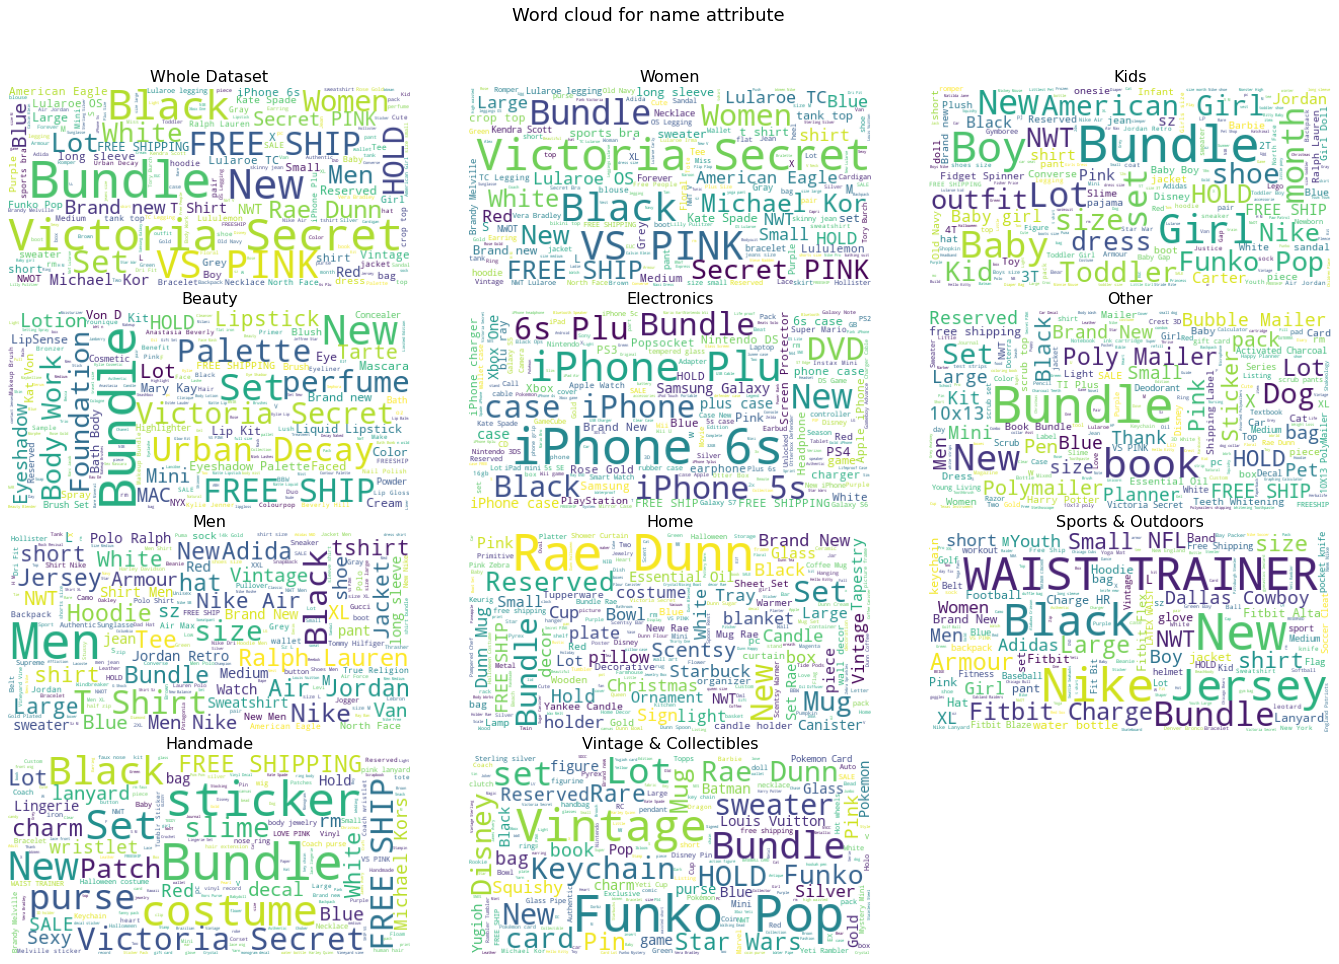

In [11]:
mcs = list(df_test['main_cat'].unique())
plot_wordclouds(
    [df_test['name']]+ [df_test.loc[df_test['main_cat'] == mc, 'name'] for mc in mcs],
    ['Whole Dataset']+ mcs,
    'Word cloud for name attribute')

Average number of words in name: 4.4 words


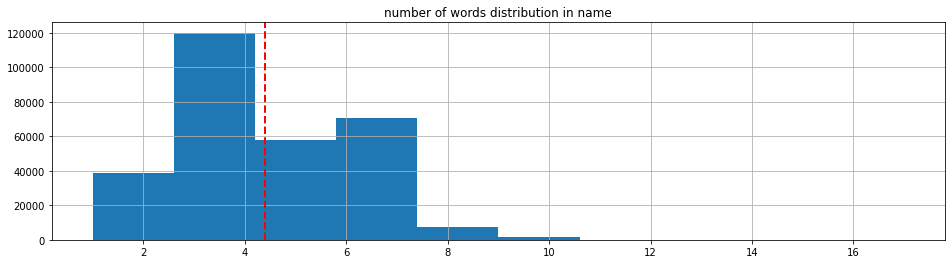

In [12]:
series_ = df_test['name'].apply(lambda x: len(x.split()))
plot_hist(series_, bins=10, title='number of words distribution in name')
print(f'Average number of words in name: {series_.mean():.1f} words')

### description analysis

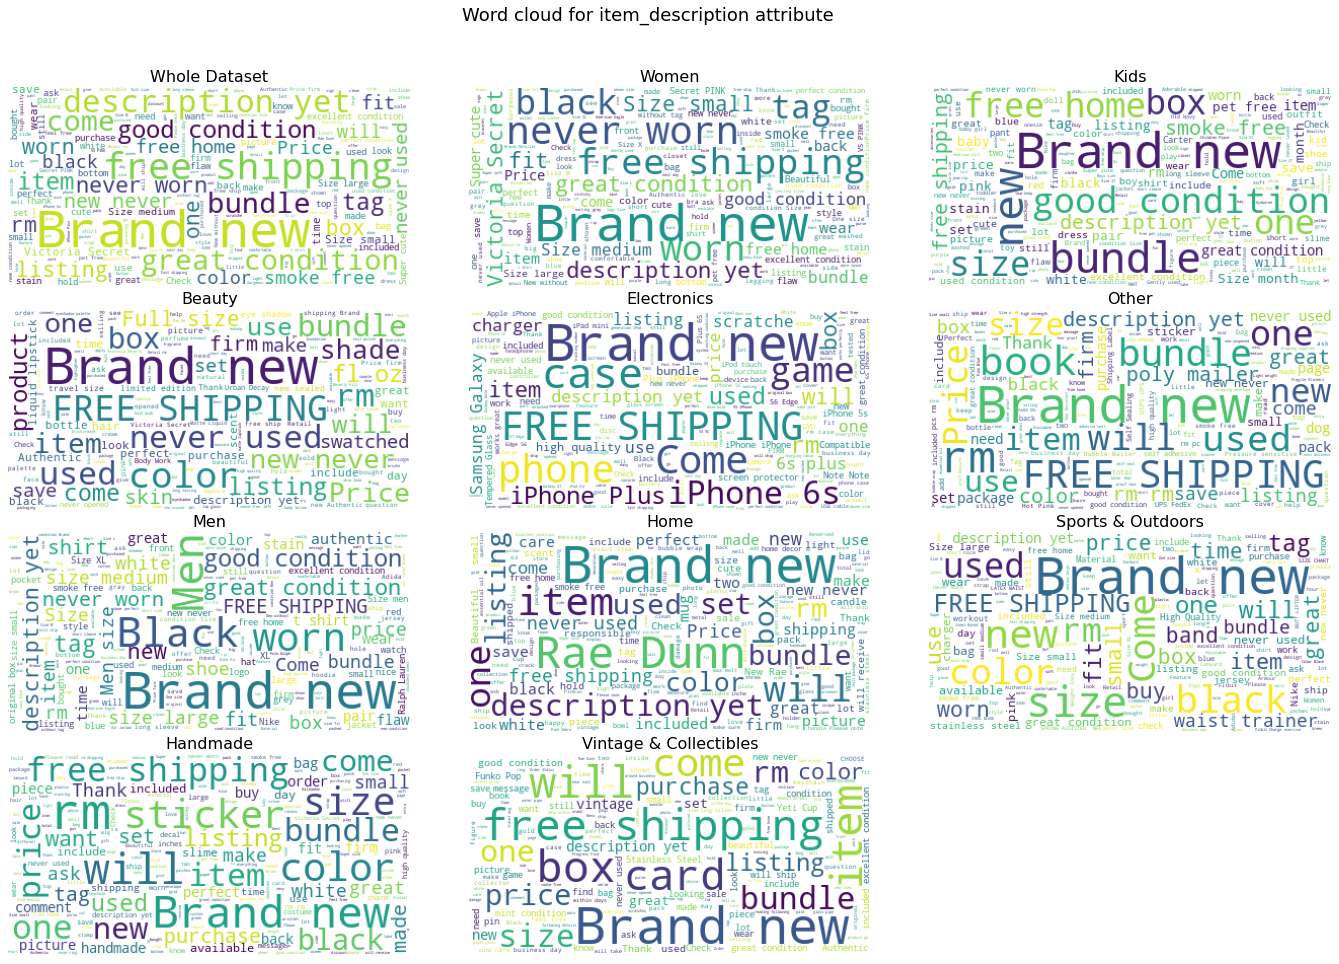

In [13]:
mcs = list(df_test['main_cat'].unique())
plot_wordclouds(
    [df_test['item_description']]+ [df_test.loc[df_test['main_cat'] == mc, 'item_description'] for mc in mcs],
    ['Whole Dataset']+ mcs,
    'Word cloud for item_description attribute')

Average number of words in item_description: 25.7 words


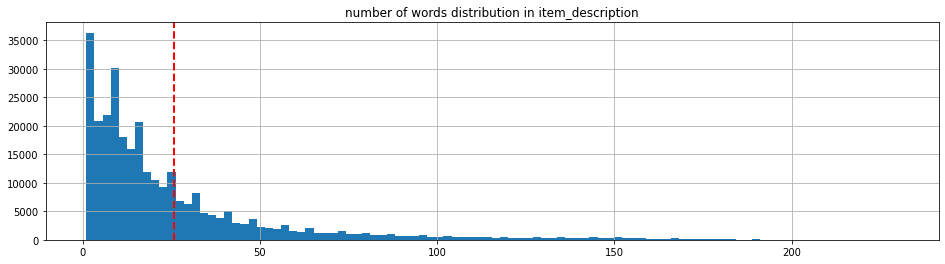

In [14]:
series_ = df_test['item_description'].apply(lambda x: len(x.split()))
plot_hist(series_, bins=100, title='number of words distribution in item_description')
print(f'Average number of words in item_description: {series_.mean():.1f} words')

### How about the language in test set

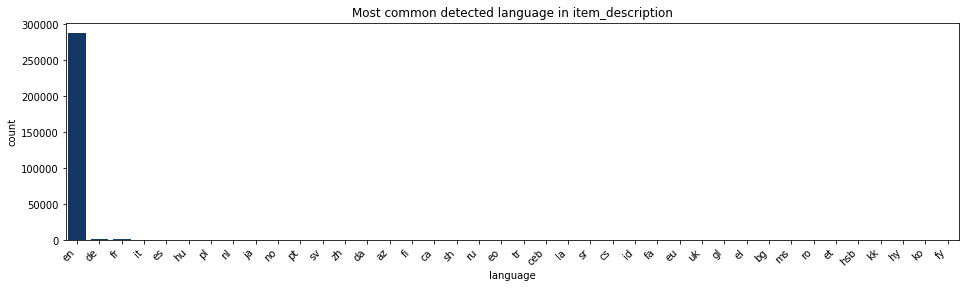

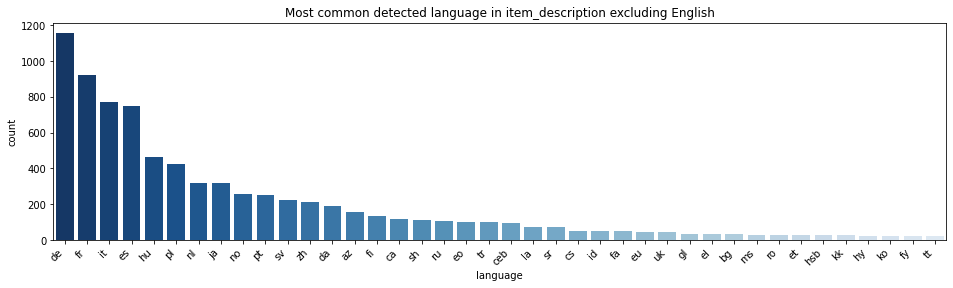

In [15]:
df_test['item_description_lang'] = df_test['item_description'].apply(lambda x: fmodel.predict(x, k=1)[0][0][len('__label__'):])
df_ = df_test.groupby('item_description_lang')['name'].count().reset_index()
df_test.drop('item_description_lang', axis=1, inplace=True)
df_.columns = ['language', 'count']
df_ = df_.sort_values('count', ascending=False)

plot_bars('Most common detected language in item_description', df_, x='language', y='count', n_bars=40)
plot_bars('Most common detected language in item_description excluding English', df_.iloc[1:], x='language', y='count', n_bars=40)

## Error analysis
<hr >

In [16]:
msle = np.mean((np.log1p(df_test['pred_price']) - np.log1p(df_test['price']))** 2)
print(f'Test dataset msle: {msle}')

Test dataset msle: 0.1917824217759911


In [17]:
len_zeros = df_test[df_test['price'] == 0].shape[0]
print(f'We have {len_zeros} items have price of zero we will exclode them for our analysis purpose')
df_test = df_test[df_test['price'] != 0]

We have 173 items have price of zero we will exclode them for our analysis purpose


### quick look into test data and our predictions

> We will use absolute error and absolute percentge error for analysis

In [18]:
df_test['abs_err'] = np.abs(df_test['price']- df_test['pred_price'])
df_test['abs_perc_err'] = df_test['abs_err']/ df_test['price']
df_test

name item_condition_id  \
0                       On hold for Chelseychu          Like new   
1                             Lace up leggings          Like new   
2            Zipper High Top All Star Converse              Good   
3                                       Sperry              Good   
4                                 Lipsense set               New   
...                                        ...               ...   
296502                              Hatchimals               New   
296503  Men's Medium Beige Columbia Sweatshirt              Good   
296504                        Tommy Hilfiger T              Good   
296505  Womens Stretchy Plus Size Dress Sz 2XL               New   
296506                New medium carly lularoe               New   

                                    category_name      brand_name  \
0             Women/Women's Handbags/Shoulder Bag     Hello Kitty   
1                        Women/Pants/Casual Pants           Other   
2                    Women/Shoes/Fashion Sneakers        Converse   
3                          Kids/Girls 2T-5T/Shoes           Other   
4                              Beauty/Makeup/Lips       SeneGence   
...                                           ...             ...   
296502          Kids/Toys/Stuffed Animals & Plush           Other   
296503  Men/Sweats & Hoodies/Sweatshirt, Pullover        Columbia   
296504              Women/Tops & Blouses/T-Shirts  Tommy Hilfiger   
296505                  Women/Dresses/Knee-Length           Other   
296506             Women/Dresses/Asymmetrical Hem         LuLaRoe   

             shipping                                   item_description  \
0       Free shipping  Black faux leather hello kitty satchel comes w...   
1       Shipping fees                              Only worn for picture   
2       Free shipping  Size 7 women's Great for your feet! Check out ...   
3       Free shipping  Pink Size 6 toddler Used Very good condition G...   
4       Shipping fees     Bella color with Glossy gloss and oops remover   
...               ...                                                ...   
296502  Free shipping  Hatchimals Hatchimals Penguala pink/yellow new...   
296503  Free shipping  Men's medium beige Columbia sweatshirt - soft ...   
296504  Free shipping  Small yellow spot next to tag, not noticeable ...   
296505  Free shipping  Womens Plus Size Dress Size 2XL New With Tags ...   
296506  Shipping fees                             New Med Purple leopard   

       main_cat  price  pred_price    abs_err  abs_perc_err  
0         Women   31.0   49.415977  18.415977      0.594064  
1         Women   15.0   10.262160   4.737840      0.315856  
2         Women   26.0   24.378532   1.621468      0.062364  
3          Kids   16.0   16.484674   0.484674      0.030292  
4        Beauty   50.0   49.983234   0.016766      0.000335  
...         ...    ...         ...        ...           ...  
296502     Kids  161.0  124.261833  36.738167      0.228187  
296503      Men   14.0   13.490439   0.509561      0.036397  
296504    Women   14.0   10.838516   3.161484      0.225820  
296505    Women   16.0   13.596390   2.403610      0.150226  
296506    Women   40.0   42.481716   2.481716      0.062043  

[296334 rows x 11 columns]

half of our predictions have absulte error less than 9.46


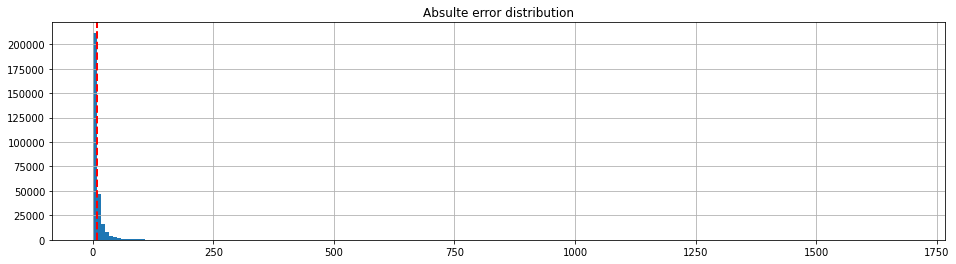

In [19]:
plot_hist(df_test['abs_err'], bins=200, title='Absulte error distribution')
abs_err_mean = df_test['abs_err'].mean()
print(f'half of our predictions have absulte error less than {abs_err_mean:.2f}')

half of our predictions have absulte error less than 0.36


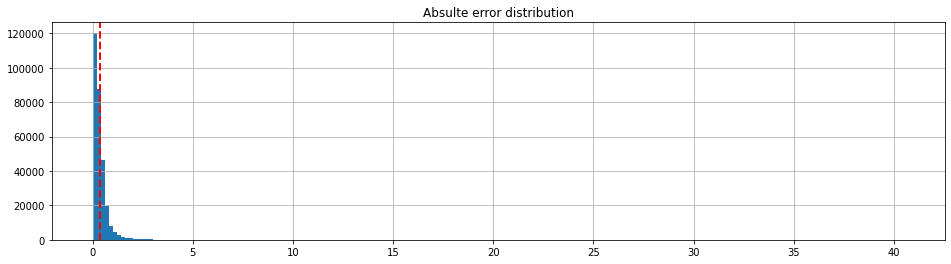

In [20]:
plot_hist(df_test['abs_perc_err'], bins=200, title='Absulte error distribution')
abs_perc_err_mean = df_test['abs_perc_err'].mean()
print(f'half of our predictions have absulte error less than {abs_perc_err_mean:.2f}')

### a quick look on the top worst predictions

In [21]:
df_test.sort_values('abs_err').tail(25)

name item_condition_id  \
270561                              VS Pink Dogs               New   
180167   MONOGRAM SAINT LAURENT WALLET MATELASSÉ               New   
142999       universal Unlocked IPhone 7 128gigs               New   
268295                     Louis Vuitton luggage              Good   
33186                Giorgio Armani fabric power               New   
44717                             IPhone 6s Plus               New   
38593                  10 [rm] ITunes gift cards               New   
155399   RESERVED Platinum Engagement Ring 1 TCW              Fair   
96985                  Super Huge Custom Listing              Fair   
173561             Apple MacBook WINTAWONDERLAND          Like new   
129737               Celine Luggage Handbag Mini          Like new   
43621                     MCM Embellished Bundle               New   
234631       14k WG 1.29CT DIAMOND STUD Earrings               New   
291085          Louis Vuitton Wallet, Neverfull.              Good   
240788              Authentic saint Laurent bag.          Like new   
110722  Reducing price for 1 day MacBook Pro15in          Like new   
86245                         Rex Ronan snes cib              Good   
182302                          Goyard Messenger               New   
6024            ✳️Bundle for Jojo✳️ Michael Kors               New   
143509         Louis Vuitton Metis Messenger Bag              Good   
142235                        Urban Decay bundle               New   
275418    Lovely Auth. Chanel Boy lambskin Italy          Like new   
164366  Used iPadPro12.9+keyboard +pen+projector              Good   
2218                Huge 84 pc. LulaRoe lot. NWT               New   
288033   ✳️Bundle for Jojo ✳️watches & bracelets               New   

                                            category_name         brand_name  \
270561                    Women/Women's Accessories/Other  Victoria's Secret   
180167                Women/Women's Handbags/Shoulder Bag      Saint Laurent   
142999  Electronics/Cell Phones & Accessories/Cell Pho...              Apple   
268295     Vintage & Collectibles/Bags and Purses/Luggage      Louis Vuitton   
33186                                  Beauty/Makeup/Face     Georgio Armani   
44717   Electronics/Cell Phones & Accessories/Cell Pho...              Other   
38593                   Other/Office supplies/Electronics              Other   
155399                                Women/Jewelry/Rings              Other   
96985           Vintage & Collectibles/Collectibles/Other              Other   
173561  Electronics/Computers & Tablets/Laptops & Netb...              Apple   
129737            Women/Women's Handbags/Totes & Shoppers             Celine   
43621                 Women/Women's Handbags/Shoulder Bag      MCM Worldwide   
234631                             Women/Jewelry/Earrings              Other   
291085                Women/Women's Handbags/Shoulder Bag      Louis Vuitton   
240788                Women/Women's Handbags/Shoulder Bag      Saint Laurent   
110722  Electronics/Computers & Tablets/Laptops & Netb...              Apple   
86245            Electronics/Video Games & Consoles/Games              Other   
182302                Women/Women's Handbags/Shoulder Bag             Goyard   
6024                    Women/Women's Accessories/Watches       Michael Kors   
143509                Women/Women's Handbags/Shoulder Bag      Louis Vuitton   
142235                      Beauty/Makeup/Makeup Palettes        Urban Decay   
275418                Women/Women's Handbags/Shoulder Bag             Chanel   
164366  Electronics/Computers & Tablets/iPad/Tablet/eB...              Apple   
2218                        Women/Tops & Blouses/T-Shirts              Other   
288033                  Women/Women's Accessories/Watches       Michael Kors   

             shipping                                   item_description  \
270561  Free shipping  4 Victoria secret PINK college mini dog ~ N

In [22]:
df_test.sort_values('abs_perc_err').tail(25)

name item_condition_id  \
228058                          WIRED DOORBELL               New   
203176                SAMSUNG GALAXY NOTE SPEN              Good   
295574         1 month of Xbox Gold Membership               New   
282070                   David Yurman Bracelet              Fair   
32768                    Bronze Medal with COA              Good   
75103                          Adidas NMD_R1 W               New   
114502                              hatchimals               New   
251156              Oakley BATWOLF (Polarized)               New   
282964  NWT VS PINK rainbow cowl neck pullover               New   
108904                 Tiffany and Co gift box          Like new   
195639              Lululemon Slate high times          Like new   
210322   Lego 28 pcs Brick masonry profile 1x2               New   
172757                           Bape og yeezy               New   
291070     Authentic Hermes Perfume with Pouch          Like new   
191419               Supreme sticker nmd yeezy               New   
279456           Tory Burch Robinson Chain Bag              Good   
279364              Adidas uncaged ultra boost               New   
255892                  SIMILAC ALIMENTUM 7 oz               New   
277274            Coach Signature Top Zip Tote               New   
28263                           MamaRoo mobile              Good   
211252             Michael Kors protective bag          Like new   
45768       •WILDFOX• Two Hearts Malibu Hoodie               New   
94336               OtterBoxcase iPad Air 9.7"              Good   
232556              Jim Dunlop Tortex (1.14mm)               New   
41652                 Jim Dunlop Ultex (1.0mm)               New   

                                            category_name        brand_name  \
228058  Electronics/TV, Audio & Surveillance/Home Surv...             Other   
203176  Electronics/Cell Phones & Accessories/Cell Pho...           Samsung   
295574  Electronics/Video Games & Consoles/Video Gamin...              Xbox   
282070                            Women/Jewelry/Bracelets             Other   
32768         Vintage & Collectibles/Antique/Collectibles             Other   
75103                                Women/Shoes/Athletic  adidas Originals   
114502                      Kids/Toys/Dolls & Accessories             Other   
251156                   Men/Men's Accessories/Sunglasses            Oakley   
282964                           Women/Sweaters/Cowl Neck              PINK   
108904            Women/Women's Handbags/Totes & Shoppers     Tiffany & Co.   
195639     Women/Athletic Apparel/Pants, Tights, Leggings         Lululemon   
210322                            Kids/Toys/Building Toys              LEGO   
172757                        Men/Sweats & Hoodies/Hoodie              Nike   
291070                Women/Women's Handbags/Shoulder Bag            HERMES   
191419                         Men/Men's Accessories/Hats              Nike   
279456       Women/Women's Handbags/Messenger & Crossbody        Tory Burch   
279364                                 Men/Shoes/Athletic            Adidas   
255892                        Kids/Feeding/Bottle-Feeding           Similac   
277274            Women/Women's Handbags/Totes & Shoppers             Coach   
28263                Kids/Gear/Swings, Jumpers & Bouncers           mamaRoo   
211252            Women/Women's Handbags/Totes & Shoppers      Michael Kors   
45768                               Women/Sweaters/Hooded   Wildfox Couture   
94336   Electronics/Computers & Tablets/iPad/Tablet/eB...             Apple   
232556                  Other/Musical instruments/Guitars        Jim Dunlop   
41652                   Other/Musical instruments/Guitars        Jim Dunlop   

             shipping                                   item_description  \
228058  Free shipping                               Brand new never used   
203176  Shipping fees   SAMSUNG GALAXY NOTE S PEN FROM A SAMSUNG N

### which category has worst predictions

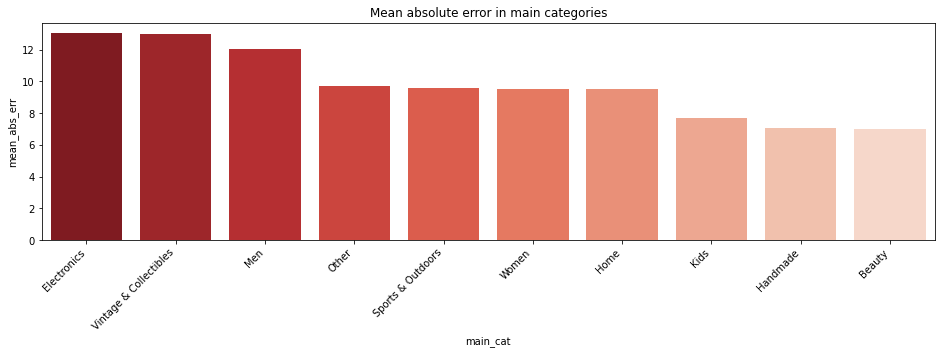

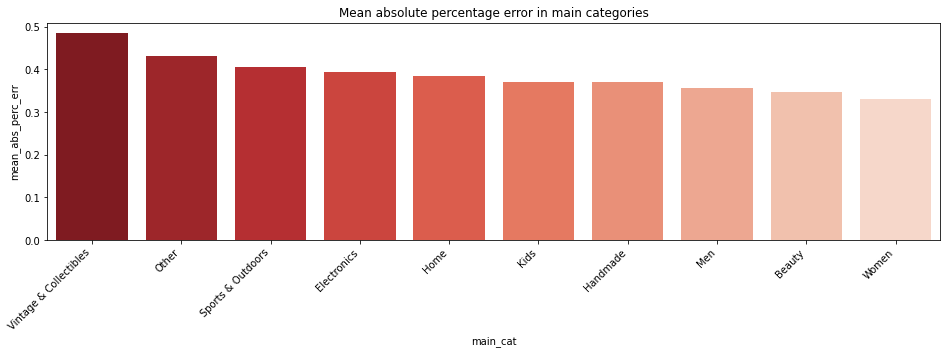

In [23]:
df_ = df_test.groupby('main_cat')['abs_err'].mean().sort_values(ascending=False).reset_index()
df_.columns = ['main_cat', 'mean_abs_err']
plot_bars('Mean absolute error in main categories', df_, x='main_cat', y='mean_abs_err', n_bars=10, palette='Reds_r')

df_ = df_test.groupby('main_cat')['abs_perc_err'].mean().sort_values(ascending=False).reset_index()
df_.columns = ['main_cat', 'mean_abs_perc_err']
plot_bars('Mean absolute percentage error in main categories', df_, x='main_cat', y='mean_abs_perc_err', n_bars=10, palette='Reds_r')

### name wordcloud based on error

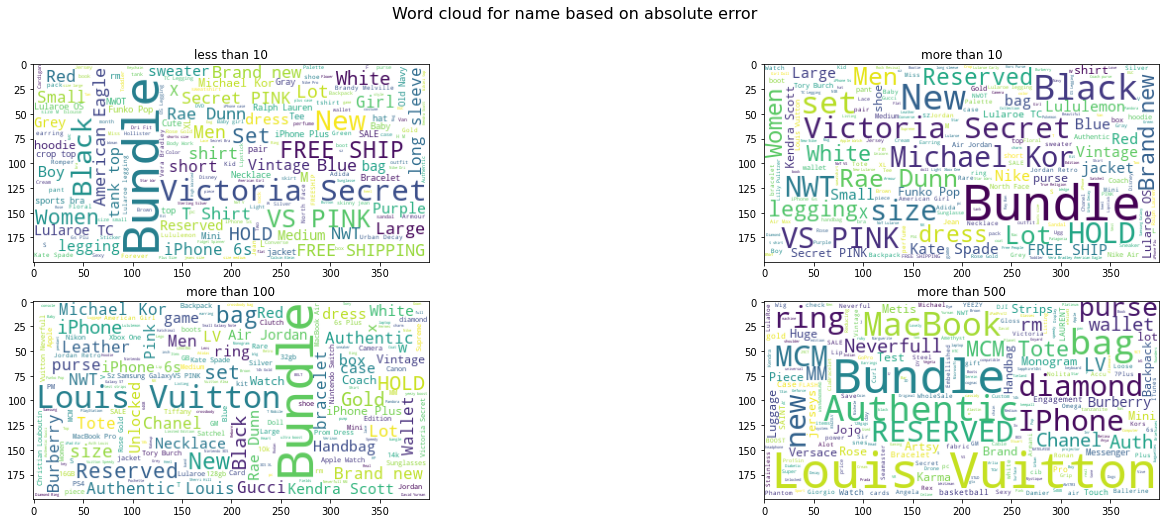

In [24]:
fig, ax = plt.subplots(2, 2,figsize=(24, 8))
fig.suptitle('Word cloud for name based on absolute error', fontsize=16)
for i, r in enumerate([('l', 10), ('g', 10), ('g', 100), ('g', 500)]):
    if r[0] == 'l':
        wordcloud.generate(' '.join(df_test.loc[df_test['abs_err']< r[1], 'name']))
        ax[i//2, i%2].set(title=f'less than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)
        
    else:
        wordcloud.generate(' '.join(df_test.loc[df_test['abs_err']> r[1], 'name']))
        ax[i//2, i%2].set(title=f'more than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)

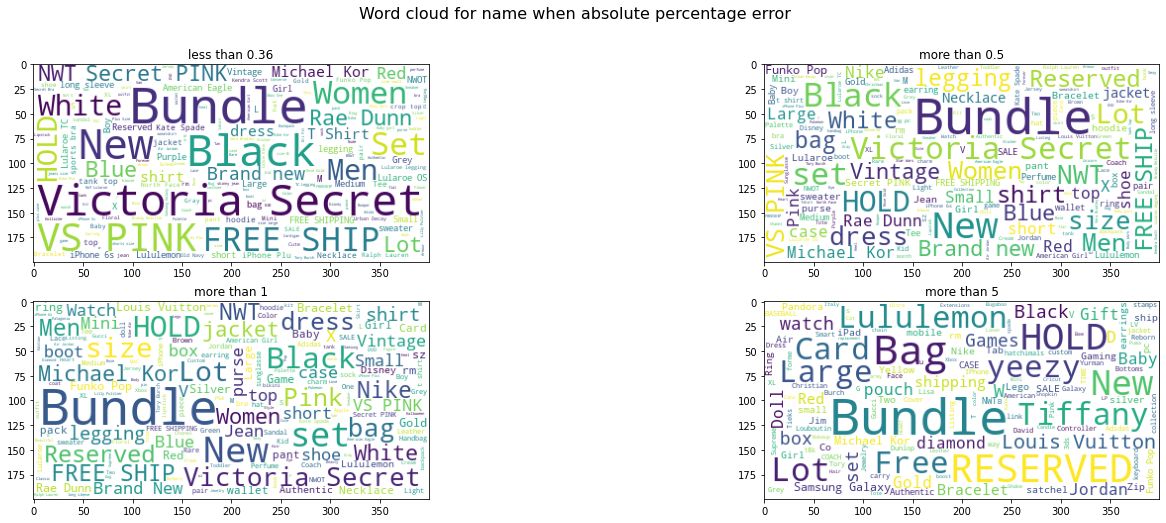

In [25]:
fig, ax = plt.subplots(2, 2,figsize=(24, 8))
fig.suptitle('Word cloud for name when absolute percentage error', fontsize=16)
for i, r in enumerate([('l', .36), ('g', .5), ('g', 1), ('g', 5)]):
    if r[0] == 'l':
        wordcloud.generate(' '.join(df_test.loc[df_test['abs_perc_err']< r[1], 'name']))
        ax[i//2, i%2].set(title=f'less than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)
        
    else:
        wordcloud.generate(' '.join(df_test.loc[df_test['abs_perc_err']> r[1], 'name']))
        ax[i//2, i%2].set(title=f'more than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)

### item_description wordcloud based on error

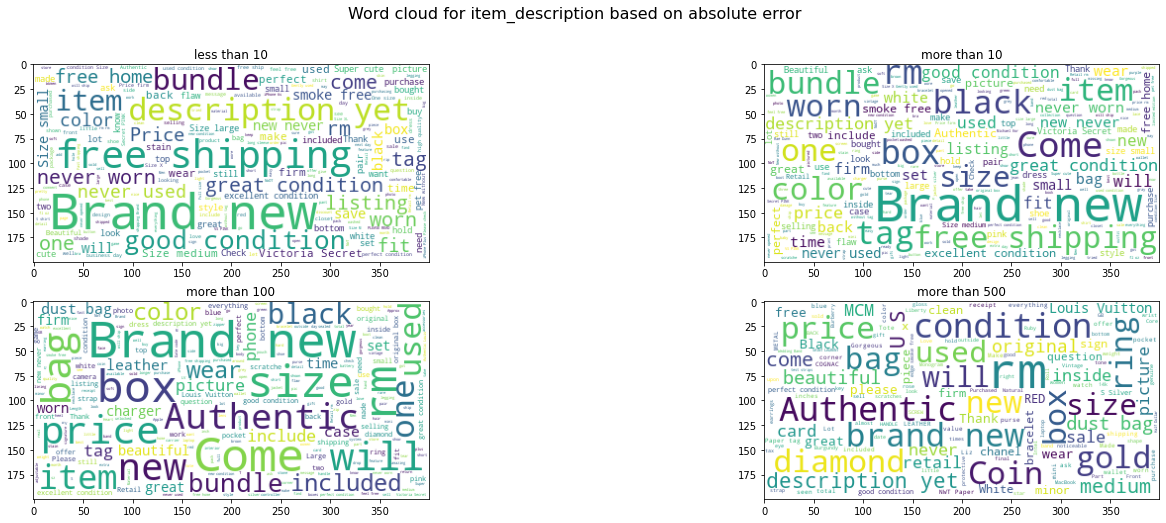

In [26]:
fig, ax = plt.subplots(2, 2,figsize=(24, 8))
fig.suptitle('Word cloud for item_description based on absolute error', fontsize=16)
for i, r in enumerate([('l', 10), ('g', 10), ('g', 100), ('g', 500)]):
    if r[0] == 'l':
        wordcloud.generate(' '.join(df_test.loc[df_test['abs_err']< r[1], 'item_description']))
        ax[i//2, i%2].set(title=f'less than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)
        
    else:
        wordcloud.generate(' '.join(df_test.loc[df_test['abs_err']> r[1], 'item_description']))
        ax[i//2, i%2].set(title=f'more than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)

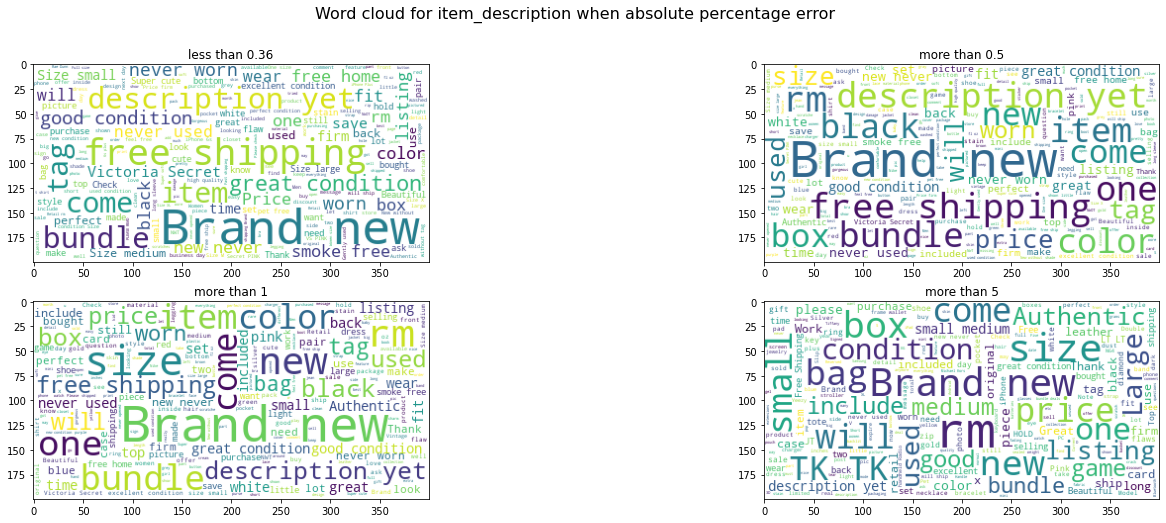

In [27]:
fig, ax = plt.subplots(2, 2,figsize=(24, 8))
fig.suptitle('Word cloud for item_description when absolute percentage error', fontsize=16)
for i, r in enumerate([('l', .36), ('g', .5), ('g', 1), ('g', 5)]):
    if r[0] == 'l':
        wordcloud.generate(' '.join(df_test.loc[df_test['abs_perc_err']< r[1], 'item_description']))
        ax[i//2, i%2].set(title=f'less than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)
        
    else:
        wordcloud.generate(' '.join(df_test.loc[df_test['abs_perc_err']> r[1], 'item_description']))
        ax[i//2, i%2].set(title=f'more than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)